In [ ]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import  Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score,  precision_score, recall_score, classification_report
from sklearn.dummy import DummyClassifier

from skmultilearn.problem_transform import LabelPowerset

In [24]:

import time
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import 
from sklearn.metrics import log_loss, accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest



In [25]:
features = pd.read_csv('../data/features_plus_descriptions.csv')
features.set_index('Feature Type and Number', inplace=True)
features.drop(['S5', 'D21'], axis=0, inplace=True)

In [26]:
target = ['H0_Best','H1_Best', 'H2_Best', 'H3_Best', 'H4_Best', 'H5_Best']

df = pd.read_csv('../data/multilabel_raw_data_tol.csv')
X = df.loc[:, features.index]
y = df[target]
y[:14]

,H0_Best,H1_Best,H2_Best,H3_Best,H4_Best,H5_Best
0,1,0,0,0,0,0
1,0,1,1,0,1,1
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
5,1,0,0,0,0,0
6,1,0,0,0,0,0
7,1,0,0,0,0,0
8,1,0,0,0,0,0
9,1,0,0,0,0,0


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    plt.rcParams['figure.dpi'] = 350
    plt.rcParams['font.size'] = 4
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
  #  classes = np.array(classes)
  #  classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [41]:
types = dict.fromkeys(features.index, 'stdsc')
mm_feats = ['S1','S3', 'S4', 'S6', 'S8','S11', 'S12', 'D3', 'D39']

for feat in mm_feats:
    types[feat] = 'minmax'

minmax_feats = []
std_feats = []

for feat in types.keys():
    if types[feat] == 'stdsc':
        std_feats.append(feat)
    elif types[feat] == 'minmax':
        minmax_feats.append(feat)

print('MinMax Scaler Features: ', minmax_feats)
print('Standard Scaler Features: ', std_feats)


preprocessor = ColumnTransformer(
    transformers=[
        ('mm_scaler', MinMaxScaler(), minmax_feats),
        ('std_scaler', StandardScaler(), std_feats)])

MinMax Scaler Features:  ['S1', 'S3', 'S4', 'S6', 'S8', 'S11', 'S12', 'D3', 'D39']
Standard Scaler Features:  ['S2', 'S7', 'S9', 'S10', 'S13', 'S14', 'D1', 'D2', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32', 'D33', 'D34', 'D35', 'D36', 'D37', 'D38']


In [29]:
def ML_pipeline_KFold_LP(X, y, preprocessor, param_grid, label_powerset):
    test_scores = []
    best_models = []
    ys = []
    for i in range(1,5):
        random_state = 431 * i
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)
        kf = KFold(n_splits=4, shuffle=True, random_state=random_state)
        clf = Pipeline([
        ('preprocessor', preprocessor), 
        ('clf', label_powerset)
        ])
        grid = GridSearchCV(clf,  param_grid, scoring='f1_macro', cv=kf, return_train_score=True, verbose=5, n_jobs=-1)   
        grid.fit(X_other, y_other)
        y_pred = grid.predict(X_test)
        prec = precision_score(y_test, y_pred, average="macro")
        rec = recall_score(y_test, y_pred, average="macro")
        f1 = f1_score(y_test, y_pred, average="macro")
        cm = confusion_matrix(label_powerset.transform(y_test), label_powerset.transform(y_pred))
        print("best estimator", grid.best_params_, "precision score", prec, "recall score", rec, "f1 score", f1)
        best_models.append(grid.best_params_)
        test_scores.append((prec, rec, f1))
        ys.append((label_powerset.transform(y_test), label_powerset.transform(y_pred), label_powerset.reverse_combinations_, label_powerset.unique_combinations_))
    return test_scores, best_models, ys

In [10]:
param_grid = {  'clf': [DummyClassifier()],
                'clf__strategy': ["stratified", "most_frequent", "prior", "uniform", "constant"]}

scores_LP_dummy, models_LP_dummy, xx = ML_pipeline_KFold_LP(X, y, preprocessor, param_grid, LabelPowerset())

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished


best estimator {'clf': DummyClassifier(strategy='uniform'), 'clf__strategy': 'uniform'} precision score 0.27542599138611373 recall score 0.5088942980557968 f1 score 0.3534253647672075
Fitting 4 folds for each of 5 candidates, totalling 20 fits
best estimator {'clf': DummyClassifier(strategy='uniform'), 'clf__strategy': 'uniform'} precision score 0.26349526952920466 recall score 0.5180798934700199 f1 score 0.34237169616330565
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


best estimator {'clf': DummyClassifier(strategy='uniform'), 'clf__strategy': 'uniform'} precision score 0.2623205762975549 recall score 0.4884508544302741 f1 score 0.33580224695806865
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


best estimator {'clf': DummyClassifier(strategy='uniform'), 'clf__strategy': 'uniform'} precision score 0.2773286923733674 recall score 0.5044969050581607 f1 score 0.35175108809210337


## Random Forest Classifier

In [ ]:
# n_jobs = -1
param_grid = {  'clf': [RandomForestClassifier()],
                'clf__max_depth': [15, 20, 25, 30, 35, 40], # 5, 7, 
                'clf__max_features': [15, 20, 25, 30, 35]} # 4, 8, 

scores_LP_RF, models_LP_RF, ys = ML_pipeline_KFold_LP(X, y, preprocessor, param_grid, LabelPowerset())


## K Nearest Neighbors Classifier

In [42]:
param_grid ={ 'clf': [KNeighborsClassifier()], 
              'clf__n_neighbors': [5,10,15,20,30,40,50,60],
              'clf__weights': ['distance', 'uniform'] }

scores_LP_KNN, models_LP_KNN, ys_LP_KNN = ML_pipeline_KFold_LP(X, y, preprocessor, param_grid, LabelPowerset())


Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:   10.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   10.6s finished


best estimator {'clf': KNeighborsClassifier(weights='distance'), 'clf__n_neighbors': 5, 'clf__weights': 'distance'} precision score 0.7108053998963872 recall score 0.5991383499554908 f1 score 0.6481764410973766
Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:   11.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   11.1s finished


best estimator {'clf': KNeighborsClassifier(weights='distance'), 'clf__n_neighbors': 5, 'clf__weights': 'distance'} precision score 0.6879775811570709 recall score 0.6209547407025001 f1 score 0.6518742731520786
Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:   11.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   11.2s finished


best estimator {'clf': KNeighborsClassifier(weights='distance'), 'clf__n_neighbors': 5, 'clf__weights': 'distance'} precision score 0.6723382492601756 recall score 0.5958014439547328 f1 score 0.6314950157675446
Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:   11.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   11.3s finished


best estimator {'clf': KNeighborsClassifier(weights='distance'), 'clf__n_neighbors': 5, 'clf__weights': 'distance'} precision score 0.7018835838934923 recall score 0.6102520607841965 f1 score 0.6519558233215222


<Figure size 3500x3500 with 0 Axes>

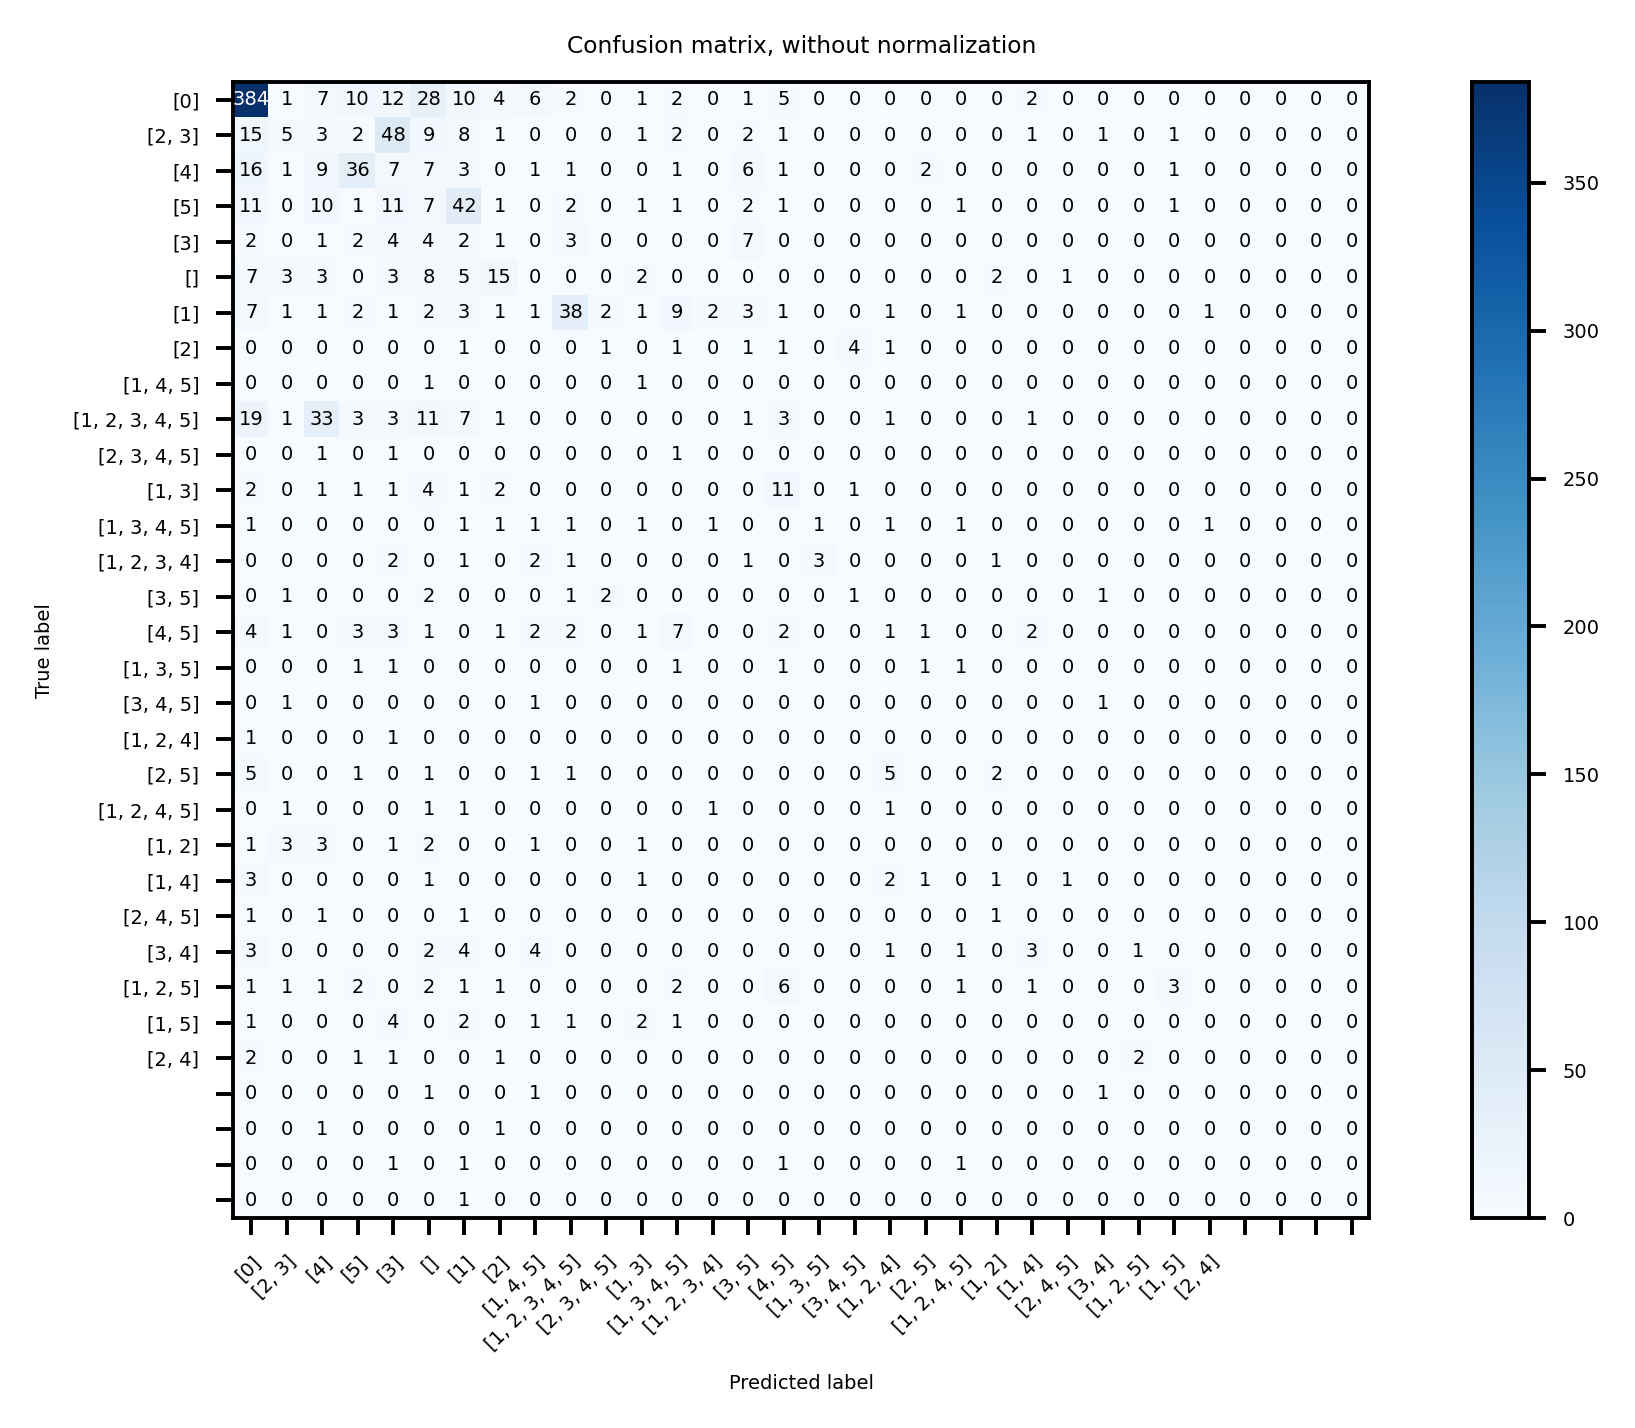

<Figure size 3500x3500 with 0 Axes>

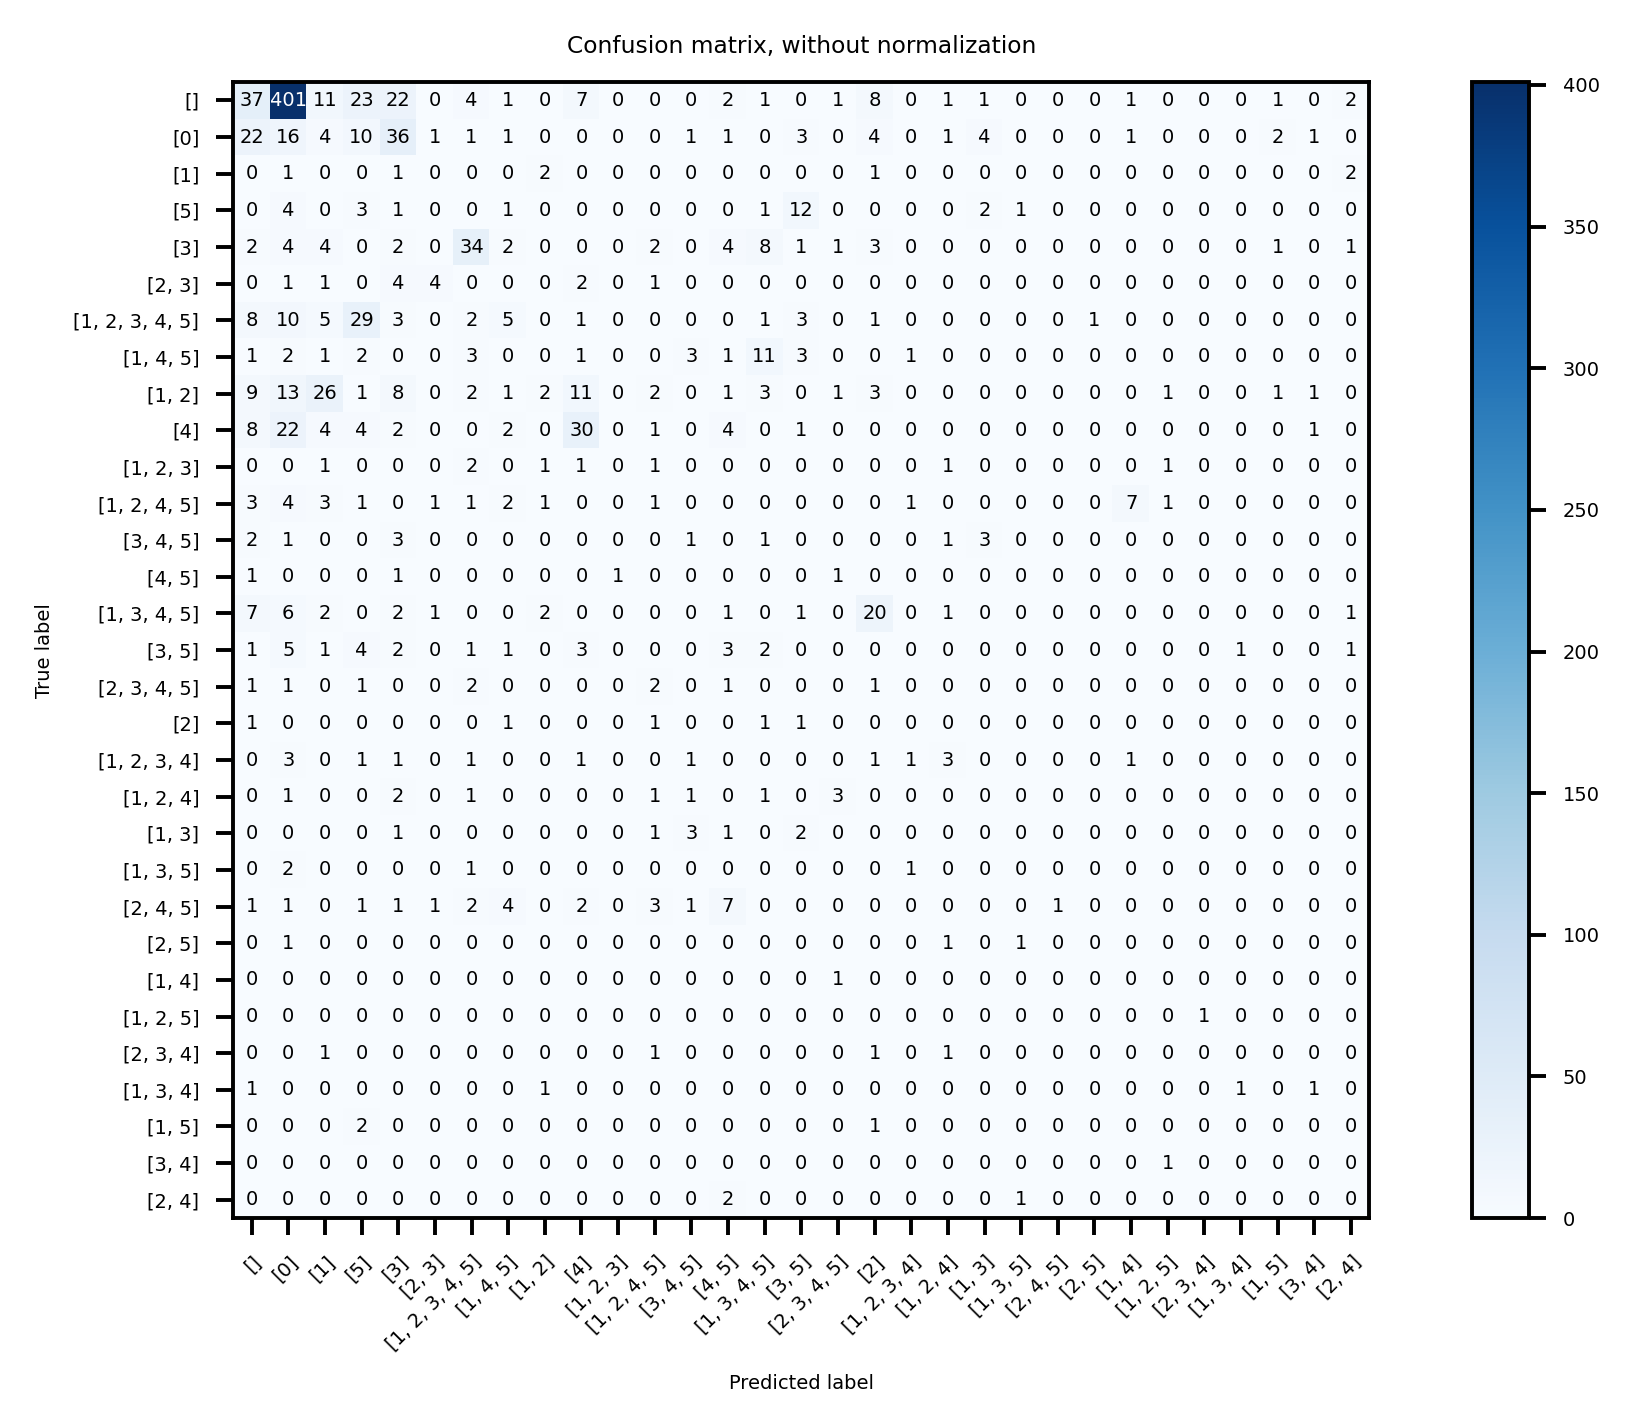

<Figure size 3500x3500 with 0 Axes>

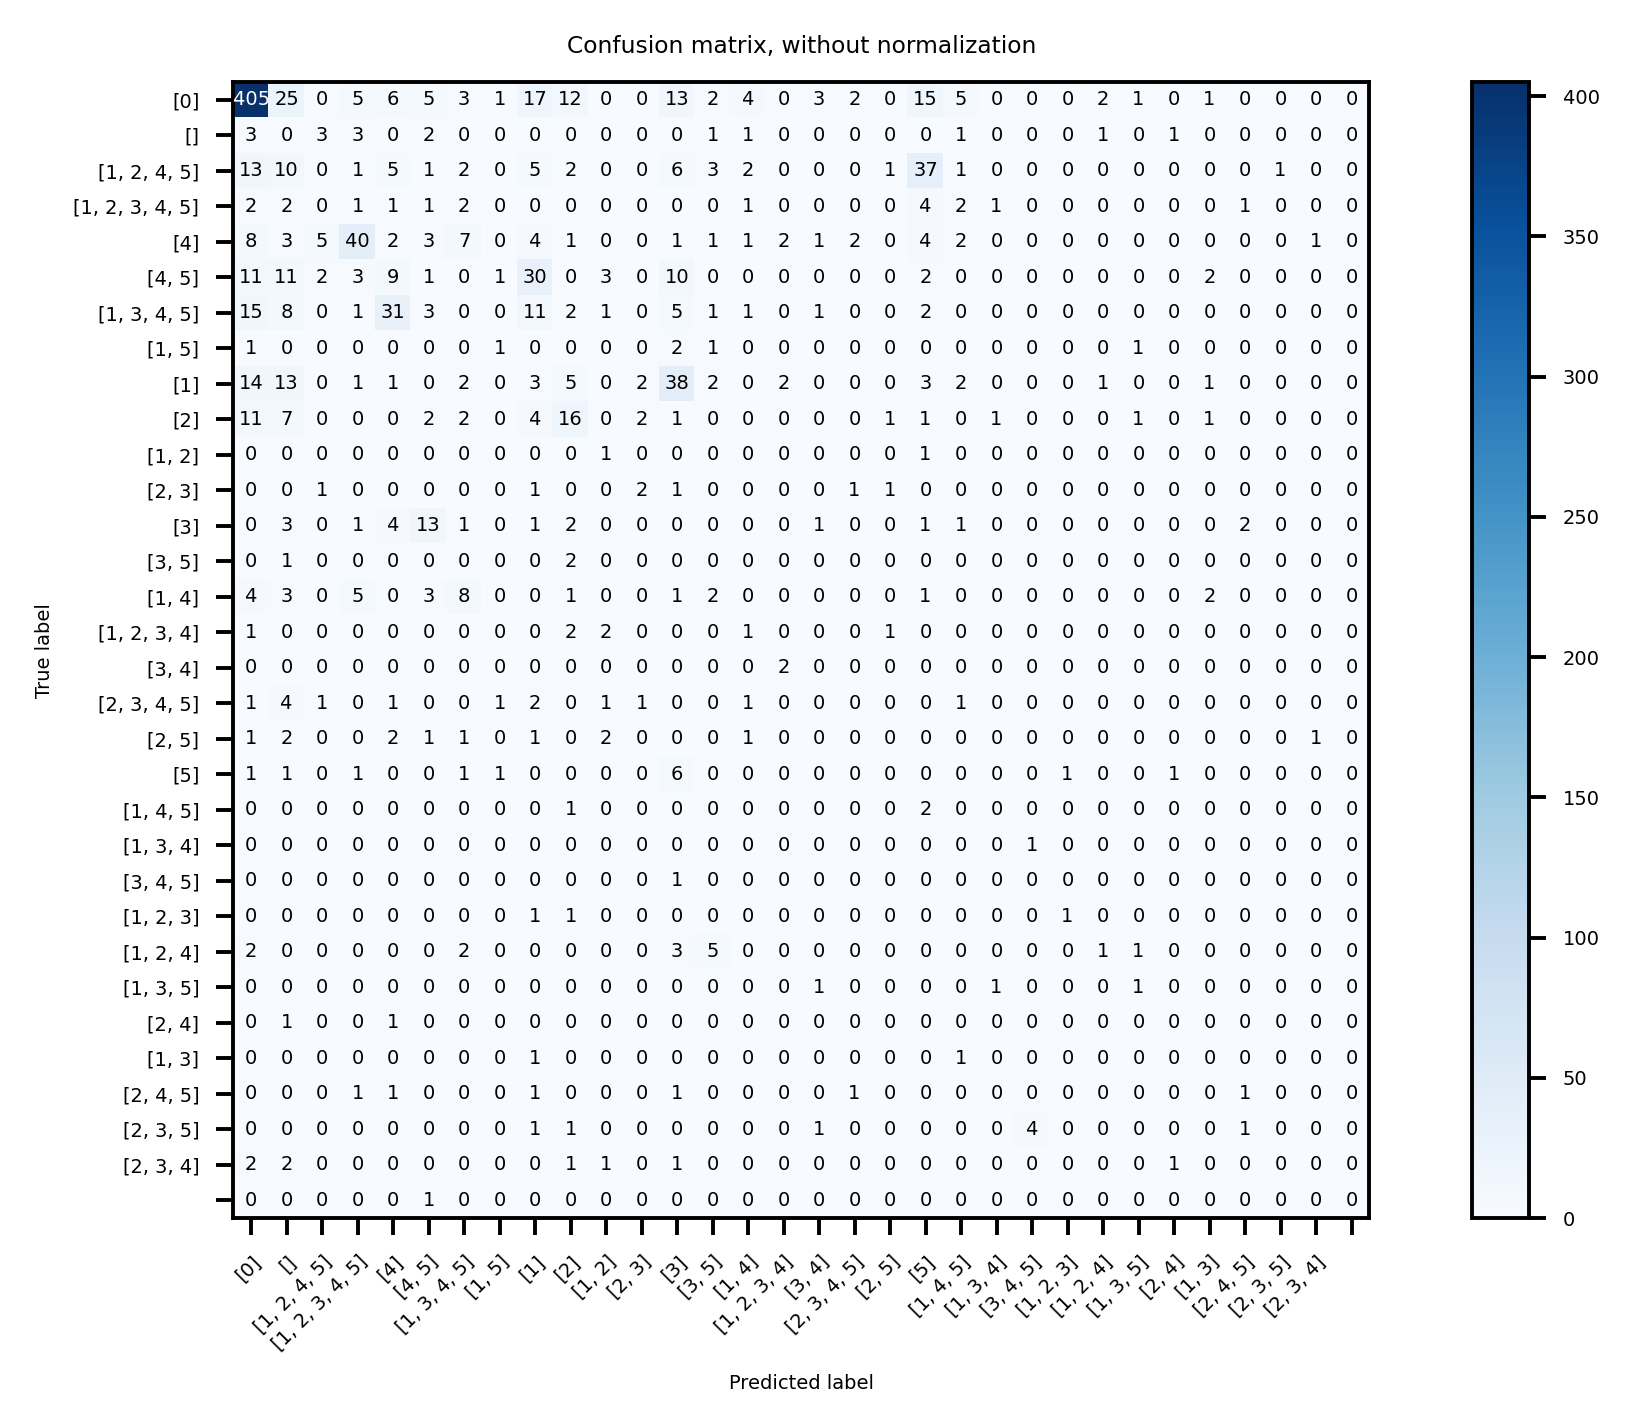

<Figure size 3500x3500 with 0 Axes>

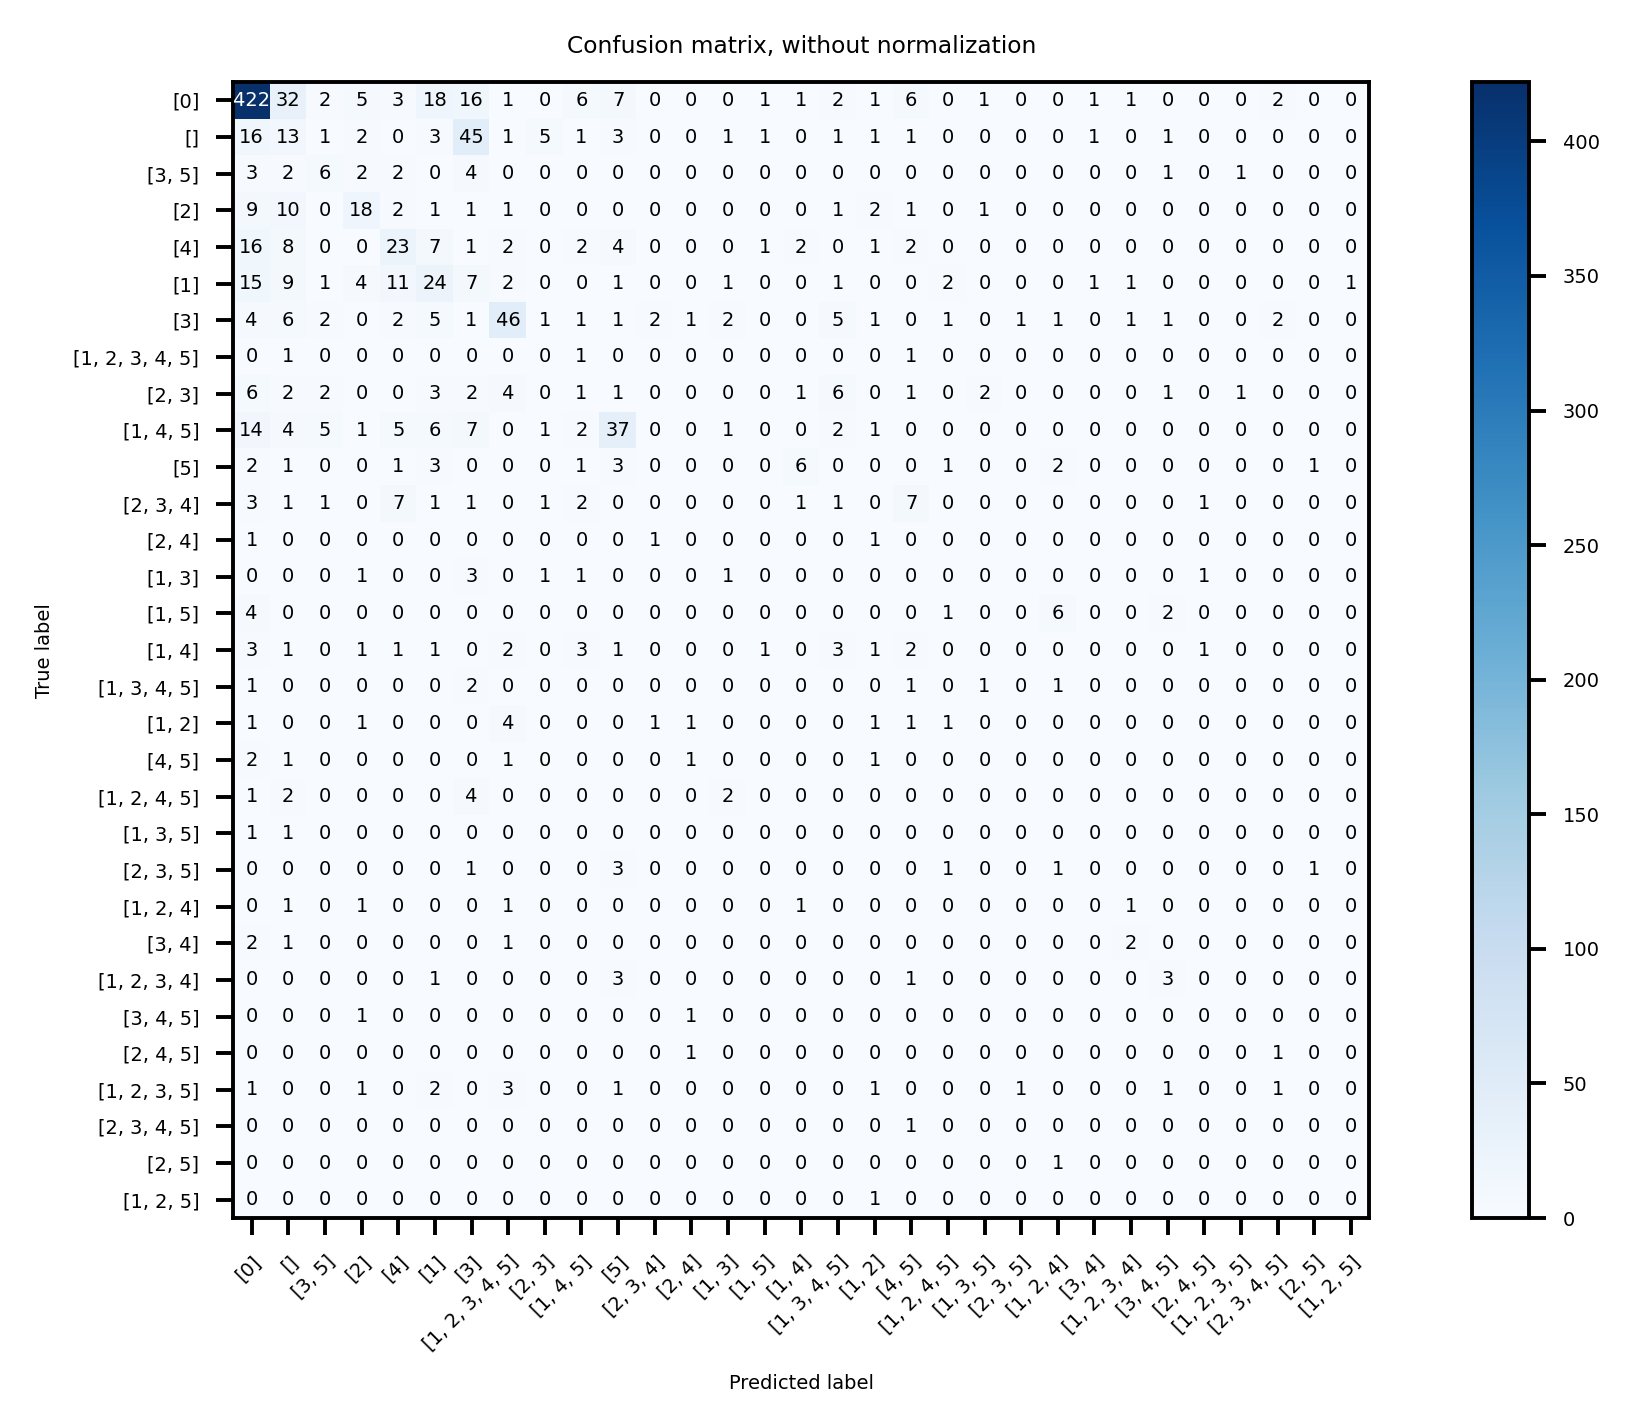

In [45]:
for yt, yp, classes, unique_combos in ys_LP_KNN:
    plot_confusion_matrix(yt, yp, classes=classes)#, normalize=True)
    
    

In [48]:
for k,v in unique_combos.items():
    print("{} :   {}".format(k, v))

0 :   0
 :   1
3,5 :   2
2 :   3
4 :   4
1 :   5
3 :   6
1,2,3,4,5 :   7
2,3 :   8
1,4,5 :   9
5 :   10
2,3,4 :   11
2,4 :   12
1,3 :   13
1,5 :   14
1,4 :   15
1,3,4,5 :   16
1,2 :   17
4,5 :   18
1,2,4,5 :   19
1,3,5 :   20
2,3,5 :   21
1,2,4 :   22
3,4 :   23
1,2,3,4 :   24
3,4,5 :   25
2,4,5 :   26
1,2,3,5 :   27
2,3,4,5 :   28
2,5 :   29
1,2,5 :   30


## Support Vector Classifier

In [17]:
np.logspace(-5,-1,num=5)
#np.logspace(-3,4, num=8)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

In [38]:
param_grid = { 'clf': [LinearSVC(max_iter=100000, verbose=5)],
               'clf__multi_class': ["crammer_singer"],
               'clf__C': np.logspace(-3,4,num=8),
               'clf__tol': np.logspace(-5, -1,num=5) }

L = LabelPowerset()

y_svc = L.transform(y)
scores_LP_KNN, models_LP_KNN, ys = ML_pipeline_KFold_LP(X, y_svc, preprocessor, param_grid, LabelPowerset())


Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.9s


KeyboardInterrupt: 

## FOR LATER:

#### `param_grid` for RF and KNN

In [ ]:
param_grid = {
        'clf': [RandomForestClassifier()],
        'clf__criterion': ['gini', 'entropy'],
    }, 


param_grid ={
        'clf': [KNeighborsClassifier()], 
        'clf__n_neighbors': [5,10,15,20,30,40,50,60,70,75],
        'clf__weights': ['distance', 'uniform']
    }